# Лабораторная работа 7
## RFM-кластеризация покупателей (по CRISP-DM)
### Выполнил Антипов Арсений

Цель: провести RFM-сегментацию клиентов на основе Recency, Frequency и Monetary метрик для выявления групп покупателей с разным поведением и предложить стратегии взаимодействия.

In [9]:
# Исправление для Windows multiprocessing (должно быть выполнено в начале)
import os
if os.name == 'nt':  # Windows
    import multiprocessing
    try:
        multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass  # Метод уже установлен

# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')  # Fallback для старых версий
sns.set_palette("husl")

# Импорт пользовательских модулей с обработкой ошибок
try:
    from data_preparation import DataPreparator
    from rfm_analysis import RFMAnalyzer
    from clustering_analysis import ClusteringAnalyzer
    from visualization_utils import VisualizationUtils
    print("Все модули успешно импортированы")
except ImportError as e:
    print(f"Ошибка импорта модулей: {e}")
    print("Убедитесь, что все файлы .py находятся в той же папке, что и ноутбук")

Ошибка импорта модулей: No module named 'sklearn'
Убедитесь, что все файлы .py находятся в той же папке, что и ноутбук


Загрузка данных и структура таблицы

In [10]:
# Загрузка данных
try:
    data = pd.read_csv('customer_segmentation_project.csv', encoding='ISO-8859-1')
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Файл customer_segmentation_project.csv не найден!")
    print("Используются демонстрационные данные")
    data = pd.DataFrame({
        'InvoiceNo': ['536365', '536365', '536366'],
        'StockCode': ['85123A', '71053', '84406B'],
        'Description': ['Product 1', 'Product 2', 'Product 3'],
        'Quantity': [6, 6, 8],
        'InvoiceDate': ['01/12/2010 08:26', '01/12/2010 08:26', '01/12/2010 08:28'],
        'UnitPrice': [2.55, 3.39, 2.75],
        'CustomerID': [17850.0, 17850.0, 17851.0],
        'Country': ['United Kingdom', 'United Kingdom', 'United Kingdom']
    })

print("Размер данных:", data.shape)
data.info()
data.head(5)

Данные успешно загружены
Размер данных: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Первичный обзор данных

In [11]:
print("Диапазон дат:", data['InvoiceDate'].min(), "до", data['InvoiceDate'].max())
print("Уникальных CustomerID:", data['CustomerID'].nunique())
print("Уникальных StockCode:", data['StockCode'].nunique())
print("Уникальных стран:", data['Country'].nunique())

print("\nТоп-5 стран по числу транзакций:")
print(data['Country'].value_counts().head())

print("\nПример кол-ва позиций в одном заказе (InvoiceNo=536365):")
print(data[data['InvoiceNo'] == '536365'].shape[0], "строк")
data[data['InvoiceNo'] == '536365'].head()

Диапазон дат: 1/10/2011 10:04 до 9/9/2011 9:52
Уникальных CustomerID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Топ-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Поиск пропусков и дубликатов

In [12]:
# Пропуски
print(data.isna().sum())

# Удаление записей без CustomerID или Description
initial_rows = data.shape[0]
data = data.dropna(subset=['CustomerID', 'Description'])
print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - data.shape[0]}")

# Удаление полных дубликатов
initial_rows = data.shape[0]
data = data.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_rows - data.shape[0]}")
print("Размер данных после очистки:", data.shape)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Удалено строк с пустым CustomerID/Description: 135080
Удалено полных дубликатов: 5225
Размер данных после очистки: (401604, 8)


Разведочный анализ: выбросы и аномалии

In [13]:
# Статистики Quantity и UnitPrice
print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))

# Возвраты и бесплатные товары
print("Количество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())
print("Количество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())

# Топ-5 по Quantity
print("Топ-5 по Quantity:")
print(data.nlargest(5, 'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000
Количество строк с Quantity < 0 (возвраты): 8872
Количество строк с UnitPrice = 0 (бесплатно): 40
Топ-5 по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300   

        UnitPrice  
540421       2.0

Подготовка данных (Data Preparation). Очистка: удаление пропусков и дубликатов

In [14]:
initial_rows = data.shape[0]
data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]
print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")
print("Отрицательных Quantity осталось:", (data['Quantity'] < 0).sum())

Удалено строк с Quantity=0 или UnitPrice=0: 40
Отрицательных Quantity осталось: 8872


Создание признака TotalPrice

In [15]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
print("Создан столбец TotalPrice")
print("Статистики TotalPrice:")
print(data['TotalPrice'].describe())

print(f"\nСтрок с отрицательной TotalPrice: {(data['TotalPrice'] < 0).sum()}")
print(f"Общая сумма возвратов: £{data[data['TotalPrice'] < 0]['TotalPrice'].sum():.2f}")

Создан столбец TotalPrice
Статистики TotalPrice:
count    401564.000000
mean         20.615691
std         430.373603
min     -168469.600000
25%           4.250000
50%          11.700000
75%          19.800000
max      168469.600000
Name: TotalPrice, dtype: float64

Строк с отрицательной TotalPrice: 8872
Общая сумма возвратов: £-608689.47


Дополнительная подготовка через класс DataPreparator

In [16]:
preparator = DataPreparator()
data_clean = preparator.prepare_data(data)
print(f"Подготовленные данные: {data_clean.shape}")
data_clean.info()

Подготовленные данные: (392692, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.5+ MB


 Расчет RFM показателей

RFM данные рассчитаны:
Количество клиентов: 4338

Пример RFM данных:
Статистики RFM показателей:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean   5019.059474    90.523744    2048.688081
std     100.012264   225.506968    8985.230220
min    4927.000000     1.000000       3.750000
25%    4944.000000    17.000000     306.482500
50%    4977.000000    41.000000     668.570000
75%    5068.750000    98.000000    1660.597500
max    5300.000000  7676.000000  280206.020000


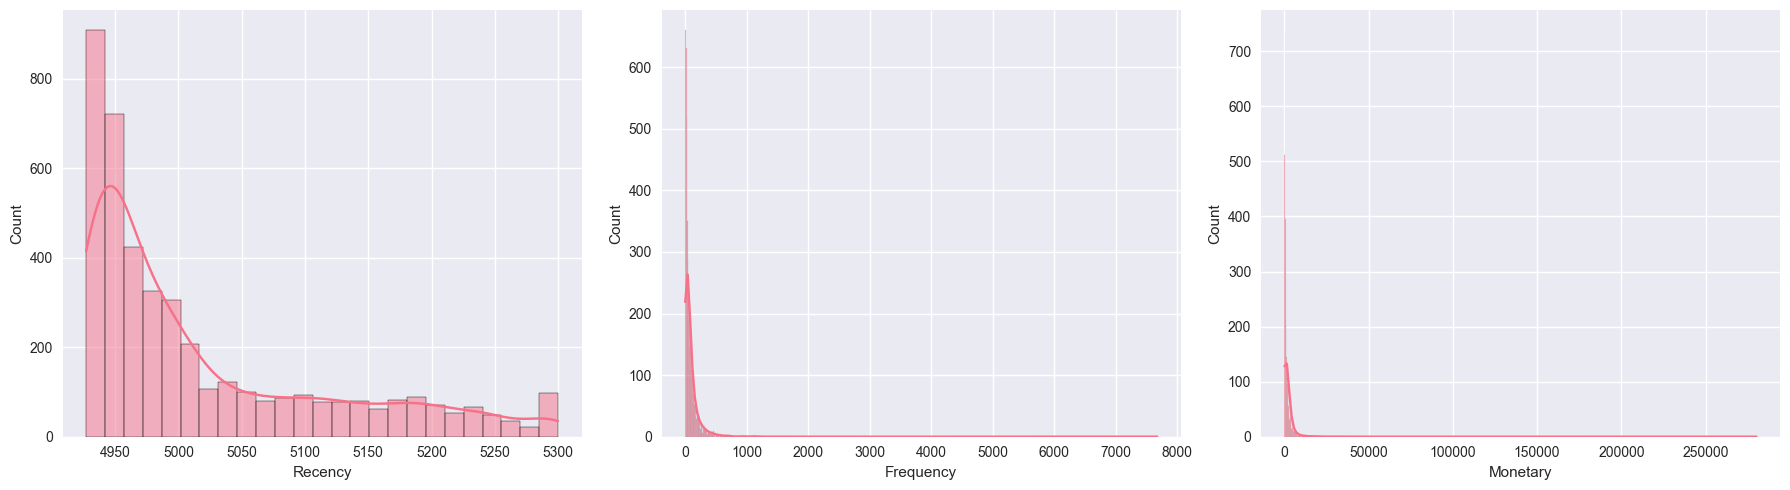

In [18]:
from visualization_utils import VisualizationUtils
rfm_analyzer = RFMAnalyzer()
rfm_data = rfm_analyzer.calculate_rfm(data_clean)
print("RFM данные рассчитаны:")
print(f"Количество клиентов: {rfm_data.shape[0]}")
print("\nПример RFM данных:")
rfm_data.head()

# Статистики RFM
print("Статистики RFM показателей:")
print(rfm_data[['Recency', 'Frequency', 'Monetary']].describe())

# Визуализация распределений
viz = VisualizationUtils()
viz.plot_rfm_distributions(rfm_data)

Моделирование (Clustering)

In [22]:
from clustering_analysis import ClusteringAnalyzer
clustering_analyzer = ClusteringAnalyzer()
rfm_scaled, scaler = clustering_analyzer.prepare_for_clustering(rfm_data)
print("Данные подготовлены для кластеризации")
print(f"Размер масштабированных данных: {rfm_scaled.shape}")

# Найти оптимальное количество кластеров
try:
    clustering_analyzer.find_optimal_clusters(rfm_scaled, max_clusters=10)
except Exception as e:
    print(f"Ошибка при поиске оптимального количества кластеров: {e}")
    print("Используется значение по умолчанию: 5 кластеров")

# Применить методы кластеризации
try:
    results = clustering_analyzer.apply_clustering_methods(rfm_scaled, n_clusters=5)
    print("Применены методы кластеризации:")
    for method, labels in results.items():
        unique_labels = len(np.unique(labels))
        if method == 'DBSCAN' and -1 in labels:
            noise_points = np.sum(labels == -1)
            print(f"{method}: {unique_labels-1} кластеров + {noise_points} шумовых точек")
        else:
            print(f"{method}: {unique_labels} кластеров")
except Exception as e:
    print(f"Ошибка при применении методов кластеризации: {e}")
    from sklearn.cluster import KMeans
    simple_kmeans = KMeans(n_clusters=5, random_state=42, n_jobs=1)
    results = {'K-means': simple_kmeans.fit_predict(rfm_scaled)}

Данные подготовлены для кластеризации
Размер масштабированных данных: (4338, 3)
Рекомендуемое количество кластеров (по Silhouette): 2
Применены методы кластеризации:
K-means: 5 кластеров
Hierarchical: 5 кластеров
GMM: 5 кластеров
Spectral: 5 кластеров
DBSCAN: 1 кластеров + 16 шумовых точек


Оценка и интерпретация результатов

Результаты оценки кластеризации:

K-means:
  silhouette: 0.614
  calinski_harabasz: 3386.756
  davies_bouldin: 0.633
  n_clusters: 5.000

Hierarchical:
  silhouette: 0.494
  calinski_harabasz: 3043.556
  davies_bouldin: 0.718
  n_clusters: 5.000

GMM:
  silhouette: 0.118
  calinski_harabasz: 469.501
  davies_bouldin: 2.168
  n_clusters: 5.000

Spectral:
  silhouette: 0.381
  calinski_harabasz: 739.583
  davies_bouldin: 0.837
  n_clusters: 5.000

DBSCAN:
  silhouette: 0.924
  calinski_harabasz: 1896.723
  davies_bouldin: 0.809
  n_clusters: 2.000
Характеристики кластеров:
             Recency                  Frequency                     Monetary  \
                mean  median count         mean  median count           mean   
Cluster                                                                        
0        4968.328067  4957.0  3228    97.898389    55.0  3228    1753.568015   
1        5174.406162  5169.0  1071    27.455649    18.0  1071     486.728049   
2        4928.500000  

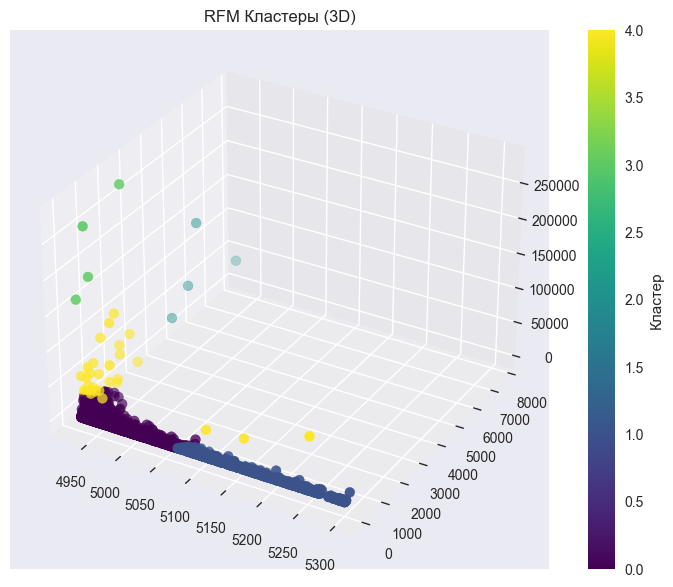

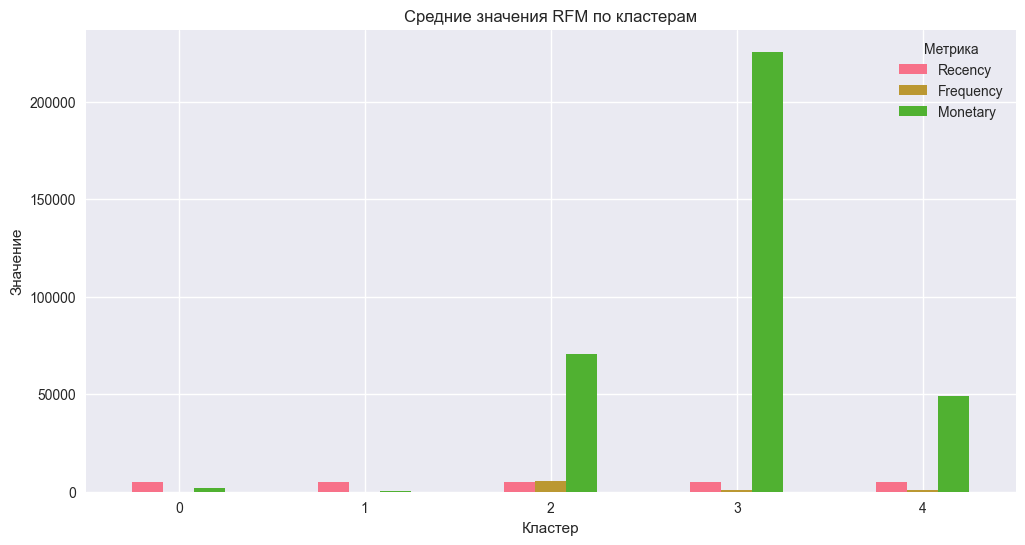

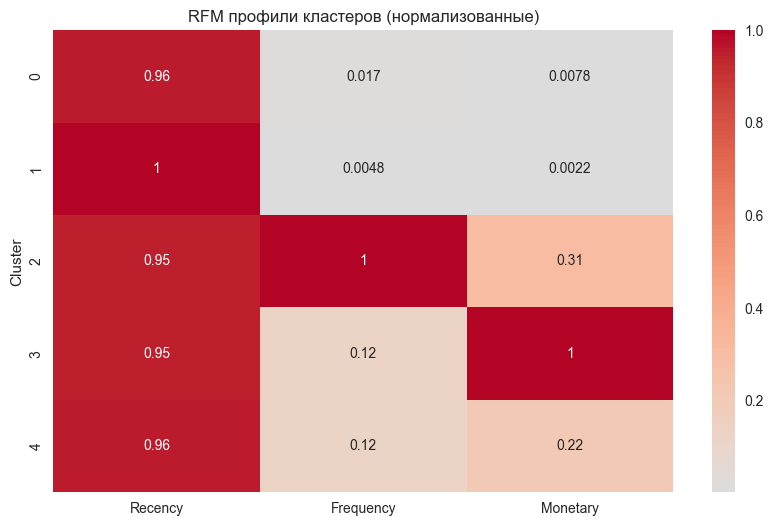

In [23]:
# Оценка качества кластеризации
evaluation_results = clustering_analyzer.evaluate_clustering(rfm_scaled, results)
print("Результаты оценки кластеризации:")
for method, scores in evaluation_results.items():
    print(f"\n{method}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score:.3f}")

# Выбор лучшего метода
best_method = 'K-means'
rfm_data['Cluster'] = results[best_method]

# Анализ характеристик кластеров
cluster_analysis = rfm_data.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'count'])
print("Характеристики кластеров:")
print(cluster_analysis)

# Визуализация кластеров
viz.plot_clusters_3d(rfm_data)
viz.plot_cluster_characteristics(rfm_data)
viz.plot_cluster_heatmap(rfm_data)

Бизнес-интерпретация и рекомендации

In [24]:
def interpret_clusters(rfm_data):
    cluster_profiles = {}
    for cluster in sorted(rfm_data['Cluster'].unique()):
        cluster_data = rfm_data[rfm_data['Cluster'] == cluster]
        avg_recency = cluster_data['Recency'].mean()
        avg_frequency = cluster_data['Frequency'].mean()
        avg_monetary = cluster_data['Monetary'].mean()
        
        if avg_recency <= 50 and avg_frequency >= 10 and avg_monetary >= 1000:
            profile = "VIP Клиенты"
            strategy = "Персональные предложения, эксклюзивные акции"
        elif avg_recency <= 100 and avg_frequency >= 5:
            profile = "Лояльные клиенты"
            strategy = "Программы лояльности, перекрестные продажи"
        elif avg_recency > 200:
            profile = "Потерянные клиенты"
            strategy = "Реактивационные кампании, специальные скидки"
        elif avg_frequency == 1:
            profile = "Новые клиенты"
            strategy = "Приветственные серии, онбординг"
        else:
            profile = "Развивающиеся клиенты"
            strategy = "Стимулирование повторных покупок"
        
        cluster_profiles[cluster] = {
            'profile': profile,
            'strategy': strategy,
            'size': len(cluster_data),
            'avg_recency': avg_recency,
            'avg_frequency': avg_frequency,
            'avg_monetary': avg_monetary
        }
    return cluster_profiles

profiles = interpret_clusters(rfm_data)
print("Профили кластеров и рекомендации:")
print("=" * 50)
for cluster, info in profiles.items():
    print(f"\nКластер {cluster}: {info['profile']}")
    print(f"Размер: {info['size']} клиентов")
    print(f"Средняя давность: {info['avg_recency']:.1f} дней")
    print(f"Средняя частота: {info['avg_frequency']:.1f} покупок")
    print(f"Средняя сумма: £{info['avg_monetary']:.2f}")
    print(f"Стратегия: {info['strategy']}")
    print("-" * 40)

Профили кластеров и рекомендации:

Кластер 0: Потерянные клиенты
Размер: 3228 клиентов
Средняя давность: 4968.3 дней
Средняя частота: 97.9 покупок
Средняя сумма: £1753.57
Стратегия: Реактивационные кампании, специальные скидки
----------------------------------------

Кластер 1: Потерянные клиенты
Размер: 1071 клиентов
Средняя давность: 5174.4 дней
Средняя частота: 27.5 покупок
Средняя сумма: £486.73
Стратегия: Реактивационные кампании, специальные скидки
----------------------------------------

Кластер 2: Потерянные клиенты
Размер: 4 клиентов
Средняя давность: 4928.5 дней
Средняя частота: 5717.2 покупок
Средняя сумма: £70612.25
Стратегия: Реактивационные кампании, специальные скидки
----------------------------------------

Кластер 3: Потерянные клиенты
Размер: 4 клиентов
Средняя давность: 4929.2 дней
Средняя частота: 711.5 покупок
Средняя сумма: £225681.65
Стратегия: Реактивационные кампании, специальные скидки
----------------------------------------

Кластер 4: Потерянные клиенты


Сохранение результатов

In [25]:
rfm_data.to_csv('rfm_customer_segments.csv', index=False)
print("\nРезультаты сохранены в файл 'rfm_customer_segments.csv'")

# Итоговая сводка
print("\n" + "=" * 60)
print("ИТОГОВАЯ СВОДКА RFM-АНАЛИЗА")
print("=" * 60)
print(f"Общее количество клиентов: {rfm_data.shape[0]}")
print(f"Количество сегментов: {rfm_data['Cluster'].nunique()}")
print(f"Период анализа: {data_clean['InvoiceDate'].min()} - {data_clean['InvoiceDate'].max()}")
print(f"Общая выручка: £{rfm_data['Monetary'].sum():.2f}")
print(f"Средний чек: £{rfm_data['Monetary'].mean():.2f}")


Результаты сохранены в файл 'rfm_customer_segments.csv'

ИТОГОВАЯ СВОДКА RFM-АНАЛИЗА
Общее количество клиентов: 4338
Количество сегментов: 5
Период анализа: 2010-12-01 08:26:00 - 2011-12-09 12:50:00
Общая выручка: £8887208.89
Средний чек: £2048.69
